In [1]:
#引用相關函式

import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

import keras
import keras.backend as K
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.losses import categorical_crossentropy
from keras.layers import Input, Dense, Dropout, CuDNNGRU, Embedding

import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
# 引用Session-based Recommendations with Recurrent Neural Networks
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""    
    def __init__(self, data, sep='\t', session_key='SessionId', item_key='ItemId', time_key='Time', n_samples=-1, itemmap=None, time_sort=False):
        """
        Args:
            path: path of the csv file
            sep: separator for the csv
            session_key, item_key, time_key: name of the fields corresponding to the sessions, items, time
            n_samples: the number of samples to use. If -1, use the whole dataset.
            itemmap: mapping between item IDs and item indices
            time_sort: whether to sort the sessions by time or not
        """
        self.df = data
        self.session_key = session_key
        self.item_key = item_key
        self.time_key = time_key
        self.time_sort = time_sort
        self.add_item_indices(itemmap=itemmap)
        self.df.sort_values([session_key, time_key], inplace=True)

        # Sort the df by time, and then by session ID. That is, df is sorted by session ID and
        # clicks within a session are next to each other, where the clicks within a session are time-ordered.

        self.click_offsets = self.get_click_offsets()
        self.session_idx_arr = self.order_session_idx()
        
    def get_click_offsets(self):
        """
        Return the offsets of the beginning clicks of each session IDs,
        where the offset is calculated against the first click of the first session ID.
        """
        offsets = np.zeros(self.df[self.session_key].nunique() + 1, dtype=np.int32)
        # group & sort the df by session_key and get the offset values
        offsets[1:] = self.df.groupby(self.session_key).size().cumsum()

        return offsets

    def order_session_idx(self):
        """ Order the session indices """
        if self.time_sort:
            # starting time for each sessions, sorted by session IDs
            sessions_start_time = self.df.groupby(self.session_key)[self.time_key].min().values
            # order the session indices by session starting times
            session_idx_arr = np.argsort(sessions_start_time)
        else:
            session_idx_arr = np.arange(self.df[self.session_key].nunique())

        return session_idx_arr
    
    def add_item_indices(self, itemmap=None):
        """ 
        Add item index column named "item_idx" to the df
        Args:
            itemmap (pd.DataFrame): mapping between the item Ids and indices
        """
        if itemmap is None:
            item_ids = self.df[self.item_key].unique()  # unique item ids
            item2idx = pd.Series(data=np.arange(len(item_ids)),
                                 index=item_ids)
            itemmap = pd.DataFrame({self.item_key:item_ids,
                                   'item_idx':item2idx[item_ids].values})
        
        self.itemmap = itemmap
        self.df = pd.merge(self.df, self.itemmap, on=self.item_key, how='inner')
        
    @property    
    def items(self):
        return self.itemmap.ItemId.unique()
        

class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""    
    def __init__(self, dataset, batch_size=50):
        """
        A class for creating session-parallel mini-batches.
        Args:
            dataset (SessionDataset): the session dataset to generate the batches from
            batch_size (int): size of the batch
        """
        self.dataset = dataset
        self.batch_size = batch_size
        self.done_sessions_counter = 0
        
    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        df = self.dataset.df
        session_key='SessionId'
        item_key='ItemId'
        time_key='TimeStamp'
        self.n_items = df[item_key].nunique()+1
        click_offsets = self.dataset.click_offsets
        session_idx_arr = self.dataset.session_idx_arr

        iters = np.arange(self.batch_size)
        maxiter = iters.max()
        start = click_offsets[session_idx_arr[iters]]
        end = click_offsets[session_idx_arr[iters] + 1]
        mask = [] # indicator for the sessions to be terminated
        finished = False        

        while not finished:
            minlen = (end - start).min()
            # Item indices (for embedding) for clicks where the first sessions start
            idx_target = df.item_idx.values[start]
            for i in range(minlen - 1):
                # Build inputs & targets
                idx_input = idx_target
                idx_target = df.item_idx.values[start + i + 1]
                inp = idx_input
                target = idx_target
                yield inp, target, mask
                
            # click indices where a particular session meets second-to-last element
            start = start + (minlen - 1)
            # see if how many sessions should terminate
            mask = np.arange(len(iters))[(end - start) <= 1]
            self.done_sessions_counter = len(mask)
            for idx in mask:
                maxiter += 1
                if maxiter >= len(click_offsets) - 1:
                    finished = True
                    break
                # update the next starting/ending point
                iters[idx] = maxiter
                start[idx] = click_offsets[session_idx_arr[maxiter]]
                end[idx] = click_offsets[session_idx_arr[maxiter] + 1]


def create_model(args):   
    emb_size = 50
    hidden_units = 100
    size = emb_size

    inputs = Input(batch_shape=(args.batch_size, 1, args.train_n_items))
    gru, gru_states = CuDNNGRU(hidden_units, stateful=True, return_state=True)(inputs)
    drop2 = Dropout(0.25)(gru)
    predictions = Dense(args.train_n_items, activation='softmax')(drop2)
    model = Model(inputs=inputs, outputs=[predictions])
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss=categorical_crossentropy, optimizer=opt)
    model.summary()

    filepath='model_checkpoint.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=2, save_best_only=True, mode='min')
    callbacks_list = []
    return model


def get_states(model):
    return [K.get_value(s) for s,_ in model.state_updates]


def get_metrics(model, args, train_generator_map, recall_k=20, mrr_k=20):

    test_dataset = SessionDataset(args.test_data, itemmap=train_generator_map)
    test_generator = SessionDataLoader(test_dataset, batch_size=args.batch_size)

    n = 0
    rec_sum = 0
    mrr_sum = 0

    with tqdm(total=args.test_samples_qty) as pbar:
        for feat, label, mask in test_generator:

            target_oh = to_categorical(label, num_classes=args.train_n_items)
            input_oh  = to_categorical(feat,  num_classes=args.train_n_items) 
            input_oh = np.expand_dims(input_oh, axis=1)
            
            pred = model.predict(input_oh, batch_size=args.batch_size)

            for row_idx in range(feat.shape[0]):
                pred_row = pred[row_idx] 
                label_row = target_oh[row_idx]

                rec_idx =  pred_row.argsort()[-recall_k:][::-1]
                mrr_idx =  pred_row.argsort()[-mrr_k:][::-1]
                tru_idx = label_row.argsort()[-1:][::-1]

                n += 1

                if tru_idx[0] in rec_idx:
                    rec_sum += 1

                if tru_idx[0] in mrr_idx:
                    mrr_sum += 1/int((np.where(mrr_idx == tru_idx[0])[0]+1))
            
            pbar.set_description("Evaluating model")
            pbar.update(test_generator.done_sessions_counter)

    recall = rec_sum/n
    mrr = mrr_sum/n
    return (recall, recall_k), (mrr, mrr_k)


def train_model(model, args, save_weights = False):
    train_dataset = SessionDataset(args.train_data)
    model_to_train = model
    batch_size = args.batch_size
    
   
    x = [i for i in range(1,10)]
    y_recall = []
    y_mrr = []
    
    for epoch in range(1, 10):
        with tqdm(total=args.train_samples_qty) as pbar:
            loader = SessionDataLoader(train_dataset, batch_size=batch_size)
            for feat, target, mask in loader:
                
                real_mask = np.ones((batch_size, 1))
                for elt in mask:
                    real_mask[elt, :] = 0

                hidden_states = get_states(model_to_train)[0]
                hidden_states = np.multiply(real_mask, hidden_states)
                hidden_states = np.array(hidden_states, dtype=np.float32)
                model_to_train.layers[1].reset_states(hidden_states)

                input_oh = to_categorical(feat, num_classes=loader.n_items) 
                input_oh = np.expand_dims(input_oh, axis=1)

                target_oh = to_categorical(target, num_classes=loader.n_items)

                tr_loss = model_to_train.train_on_batch(input_oh, target_oh)

                pbar.set_description("Epoch {0}. Loss: {1:.5f}".format(epoch, tr_loss))
                pbar.update(loader.done_sessions_counter)
            
        
        if save_weights:
            print("Saving weights...")
            model_to_train.save('GRU4REC_{}.h5'.format(epoch))
        
        
        
        (rec, rec_k), (mrr, mrr_k) = get_metrics(model_to_train, args, train_dataset.itemmap)
        y_recall.append(rec)
        y_mrr.append(mrr)

        print("\t - Recall@{} epoch {}: {:5f}".format(rec_k, epoch, rec))
        print("\t - MRR@{}    epoch {}: {:5f}".format(mrr_k, epoch, mrr))
        print("\n")
        
    plt.figure(figsize=(8,4))
    plt.plot(x,y_recall,label="recall@{}".format(rec_k))
    plt.plot(x,y_mrr,label="mrr@{}".format(mrr_k))
    plt.xlabel("epoch")
    plt.show()
        
        


訓練影片數目: 11619
訓練使用者數目: 19854
測試使用者數目: 5272
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (512, 1, 11619)           0         
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       [(512, 100), (512, 100)]  3516300   
_________________________________________________________________
dropout_1 (Dropout)          (512, 100)                0         
_________________________________________________________________
dense_1 (Dense)              (512, 11619)              1173519   
Total params: 4,689,819
Trainable params: 4,689,819
Non-trainable params: 0
_________________________________________________________________


  0%|          | 0/19854 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


Epoch 1. Loss: 2.13830: : 24422it [08:07, 50.14it/s]                         


Saving weights...


Epoch 2. Loss: 3.90081:   0%|          | 0/19854 [00:00<?, ?it/s]

	 - Recall@20 epoch 1: 0.074617
	 - MRR@20    epoch 1: 0.014418




Epoch 2. Loss: 1.89451: : 24422it [05:21, 75.99it/s]                          


Saving weights...


Epoch 3. Loss: 3.86672:   0%|          | 0/19854 [00:00<?, ?it/s]

	 - Recall@20 epoch 2: 0.078972
	 - MRR@20    epoch 2: 0.014948




Epoch 3. Loss: 1.60394: : 24422it [05:21, 75.96it/s]                          


Saving weights...


Epoch 4. Loss: 3.84048:   0%|          | 0/19854 [00:00<?, ?it/s]

	 - Recall@20 epoch 3: 0.082872
	 - MRR@20    epoch 3: 0.015361




Epoch 4. Loss: 1.48172: : 24422it [05:21, 76.07it/s]                          


Saving weights...


Epoch 5. Loss: 3.79302:   0%|          | 0/19854 [00:00<?, ?it/s]

	 - Recall@20 epoch 4: 0.081519
	 - MRR@20    epoch 4: 0.015205




Epoch 5. Loss: 1.51544: : 24422it [05:20, 76.22it/s]                          


Saving weights...


Epoch 6. Loss: 3.75365:   0%|          | 0/19854 [00:00<?, ?it/s]

	 - Recall@20 epoch 5: 0.082587
	 - MRR@20    epoch 5: 0.015308




Epoch 6. Loss: 1.51202: : 24422it [05:22, 75.73it/s]                          


Saving weights...


Epoch 7. Loss: 3.74830:   0%|          | 0/19854 [00:00<?, ?it/s]

	 - Recall@20 epoch 6: 0.082606
	 - MRR@20    epoch 6: 0.015379




Epoch 7. Loss: 1.51851: : 24422it [05:23, 75.48it/s]                          


Saving weights...


Epoch 8. Loss: 3.72219:   0%|          | 0/19854 [00:00<?, ?it/s]

	 - Recall@20 epoch 7: 0.083390
	 - MRR@20    epoch 7: 0.015447




Epoch 8. Loss: 1.57343: : 24422it [05:23, 75.55it/s]                          


Saving weights...


Epoch 9. Loss: 3.58998:   0%|          | 0/19854 [00:00<?, ?it/s]

	 - Recall@20 epoch 8: 0.084117
	 - MRR@20    epoch 8: 0.015552




Epoch 9. Loss: 1.57474: : 24422it [05:22, 75.66it/s]                          


Saving weights...


Evaluating model:  82%|████████▏ | 4327/5272 [03:52<00:50, 18.63it/s]

	 - Recall@20 epoch 9: 0.084041
	 - MRR@20    epoch 9: 0.015591




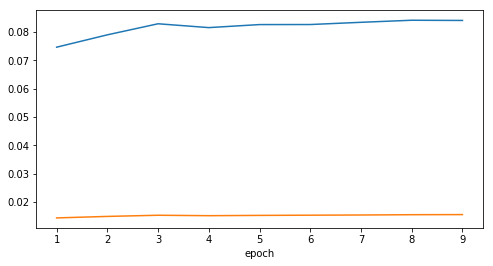

In [3]:
# 建立DataSet物件
class DataSet():
    def __init__(self):
        pass

dataSet = DataSet()

# 寫入物件所需參數 
# batch_size
dataSet.batch_size = 512
# 處理過的訓練資料
dataSet.train_data = pd.read_csv("data/augmented_train.csv", sep='\t', dtype={'ItemId': np.int64})
# 開發資料
dataSet.dev_data   = pd.read_csv("data/dev.csv",   sep='\t', dtype={'ItemId': np.int64})
# 測試資料
dataSet.test_data  = pd.read_csv("data/test.csv",  sep='\t', dtype={'ItemId': np.int64})
# 影片數目
dataSet.train_n_items = len(dataSet.train_data['ItemId'].unique()) + 1
print("訓練影片數目:", dataSet.train_n_items)
# 使用者數目
dataSet.train_samples_qty = len(dataSet.train_data['SessionId'].unique()) + 1
print("訓練使用者數目:", dataSet.train_samples_qty)
dataSet.test_samples_qty = len(dataSet.test_data['SessionId'].unique()) + 1
print("測試使用者數目:", dataSet.test_samples_qty)

# 建立模型
model = create_model(dataSet)

# 訓練模型
train_model(model, dataSet, save_weights=True)